<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [1]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
#----------------visualisation---------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#----------------keras-----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
#---------------PIL--------------------------
from PIL import Image

In [2]:
data_path = 'drive/MyDrive/faces/data'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


*Dataset is quite balanced.*

# **2. Face detection**

In [4]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def face_recognition(photo, array):
  image = cv2.imread(photo)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face = face_classifier.detectMultiScale(gray_image, 1.3, 4)
  if len(face) > 0:
   for i, (x, y, w, h) in enumerate(face):
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = image[y:y + h, x:x + w]
      array.append(face)

In [5]:
smiling_faces = []
anger_faces = []
disgust_faces = []
fear_faces = []
surprise_faces  = []

In [6]:
def faces_array(array, photos, path):
  files_folder = os.listdir(f'{path}/{photos}')
  print(f'{path}/{photos}')
  for i in range(0, len(files_folder)):
    img_path = f'{path}/{photos}/{files_folder[i]}'
    face_recognition(img_path, array)

In [7]:
faces_array(smiling_faces, "smiling-person", data_path)
faces_array(anger_faces, "anger-person", data_path)
faces_array(disgust_faces, "disgust-person", data_path)
faces_array(fear_faces, "fear-person", data_path)
faces_array(surprise_faces, "surprise-person", data_path)

drive/MyDrive/faces/data/smiling-person
drive/MyDrive/faces/data/anger-person
drive/MyDrive/faces/data/disgust-person
drive/MyDrive/faces/data/fear-person
drive/MyDrive/faces/data/surprise-person


In [8]:
recognized_faces = {
    'smiling-face': smiling_faces,
    'anger-face' : anger_faces,
    'disgust-face' : disgust_faces,
    'fear-face' : fear_faces,
    'surprise-face' : surprise_faces
}

In [9]:
faces = []
amount = []

for k in recognized_faces:
  faces.append(k)
  amount.append(len(recognized_faces[k]))

### Data visualisation

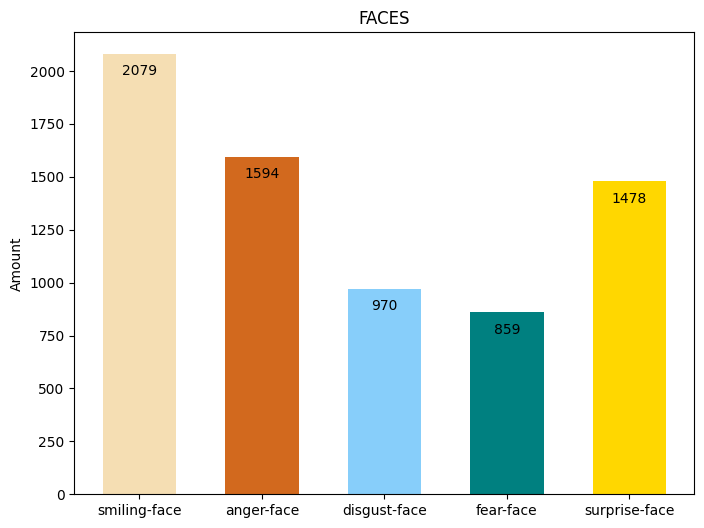

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
colors = ['wheat', 'chocolate', 'lightskyblue','teal', 'gold']
ax.bar(faces, amount, color=colors, width=0.6)
ax.set_title('FACES')
ax.set_ylabel('Amount')

for i in range(0, len(faces)):
  ax.text(faces[i], amount[i] - 100, horizontalalignment='center', s=amount[i] )

# **3. Save faces**

In [5]:
faces_path = 'drive/MyDrive/recognized_faces'

In [17]:
from PIL import Image

for face in recognized_faces:
  os.makedirs(f'{faces_path}', exist_ok=True)
  os.makedirs(f'{faces_path}/{face}', exist_ok=True)
  directory = f'drive/MyDrive/recognized_faces/{face}'
  for i in range(0, len(directory)):
    img = Image.fromarray(recognized_faces[face][i])
    filename = f'{face}_{i}'
    folder = f'drive/MyDrive/recognized_faces/{face}/{filename}.jpeg'
    img.save(folder)


# **4. Train and test set**

In [6]:
train_path = 'drive/MyDrive/recognized_faces/train'

In [7]:
test_path = 'drive/MyDrive/recognized_faces/test'

In [13]:
def create_set(faces, path, new_path, set_size):
  for face in faces:
    files_folder = os.listdir(f'{path}/{face}')
    for n in range(0, round(len(files_folder)*set_size)):
      files_folder = os.listdir(f'{path}/{face}')
      photo_number = np.random.randint(len(files_folder))
      print(photo_number)
      os.makedirs(f'{new_path}/{face}', exist_ok=True)
      os.replace(f'{path}/{face}/{files_folder[photo_number]}', f'{new_path}/{face}/{files_folder[photo_number]}')

In [14]:
faces = ['surprise-face', 'smiling-face', 'fear-face', 'disgust-face', 'anger-face']

In [ ]:
#creating train set
create_set(faces, faces_path, train_path, 0.8)

In [ ]:
#creating test set
create_set(faces, faces_path, test_path, 1)

In [8]:
img_height = 64
img_width = 64
batch_size = 10

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='training',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

val_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.3,
    seed=0,
    subset='validation',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

Found 168 files belonging to 5 classes.
Using 135 files for training.
Found 168 files belonging to 5 classes.
Using 50 files for validation.


# **5. Model**

In [10]:
img_height = 32
img_width = 32
batch_size = 20

In [11]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(32, (5,5), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.RandomRotation(factor = (-1, 1), fill_mode='reflect', interpolation='bilinear',))

model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [12]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [13]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 150,
    batch_size = batch_size)

Epoch 1/150
14/14 [==============================] - 30s 562ms/step - loss: 2.4825 - accuracy: 0.1926 - val_loss: 1.6119 - val_accuracy: 0.1800
Epoch 2/150
14/14 [==============================] - 0s 13ms/step - loss: 1.6052 - accuracy: 0.2148 - val_loss: 1.6075 - val_accuracy: 0.2000
Epoch 3/150
14/14 [==============================] - 0s 13ms/step - loss: 1.6029 - accuracy: 0.2296 - val_loss: 1.6050 - val_accuracy: 0.2000
Epoch 4/150
14/14 [==============================] - 0s 12ms/step - loss: 1.5924 - accuracy: 0.2667 - val_loss: 1.6058 - val_accuracy: 0.2000
Epoch 5/150
14/14 [==============================] - 0s 13ms/step - loss: 1.5880 - accuracy: 0.2296 - val_loss: 1.6023 - val_accuracy: 0.2600
Epoch 6/150
14/14 [==============================] - 0s 18ms/step - loss: 1.5948 - accuracy: 0.2074 - val_loss: 1.6013 - val_accuracy: 0.3200
Epoch 7/150
14/14 [==============================] - 0s 21ms/step - loss: 1.5881 - accuracy: 0.2667 - val_loss: 1.5890 - val_accuracy: 0.2600
Epoc